In [72]:
import numpy as np
import logging
import nibabel as nib
import math
import matplotlib.pyplot as plt
from numpy import linalg as LA
from skimage.segmentation import slic
from pathlib import Path
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from tqdm import tqdm_notebook as tqdm

In [73]:
def max_min_normalize(img):
    img = np.asarray(img)
    return (img-np.min(img)) / ((np.max(img)-np.min(img) + 1e-10))

def label_reconstruct(label, segments):
#     label_recon = np.zeros((label.shape[0], label.shape[1]))
    label_recon = np.zeros_like(label)
    id_list = list(np.unique(segments))
    for i in id_list:
        label_recon[np.where(segments==i)] = int(np.median(label[np.where(segments==i)].flatten()))
    return label_recon

In [74]:
path = Path('/home/tony/Documents/kits19/data/case_00040/')
image = nib.load(str(path / 'imaging.nii.gz')).get_data().astype(np.float32) 
label = nib.load(str(path / 'segmentation.nii.gz')).get_data().astype(np.int64) 

In [75]:
image.shape

(207, 512, 512)

In [84]:
N_SEG = 2048
COMPACTNESS = 0.1
image = max_min_normalize(image)
segments = slic(image.astype('double'), n_segments=N_SEG, compactness=COMPACTNESS, multichannel=False)

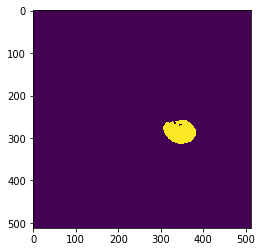

In [97]:
n_slice = 80
img_slice = image[n_slice]
label_slice = label[n_slice]
segments_slice = segments[n_slice]
plt.imshow(label_slice)

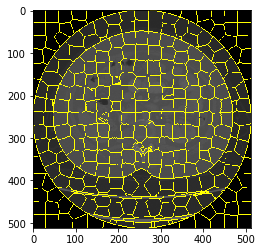

In [98]:
plt.imshow(mark_boundaries(img_slice, segments_slice))

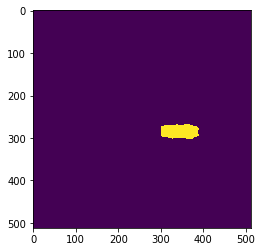

In [99]:
recon = label_reconstruct(label_slice, segments_slice)
plt.imshow(recon)

In [56]:
image = np.load('/home/tony/Documents/gcn_preprocess/kits19_3d/case_00078/image.npy')
label = np.load('/home/tony/Documents/gcn_preprocess/kits19_3d/case_00078/label.npy')
clf = np.load('/home/tony/Documents/gcn_preprocess/kits19_3d/case_00078/clf_label.npy')
image = max_min_normalize(image)

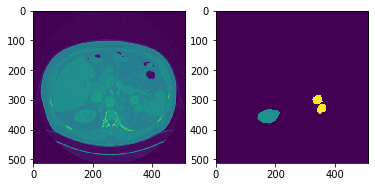

In [57]:
n_slice = 3
img_slice = image[:, :, n_slice]
label_slice = label[:, :, n_slice]
plt.subplot(1, 2, 1)
plt.imshow(img_slice)
plt.subplot(1, 2, 2)
plt.imshow(label_slice)

In [58]:
N_SEG = 2048
COMPACTNESS = 0.1
segments = slic(image.astype('double'), n_segments=N_SEG, compactness=COMPACTNESS, multichannel=False)

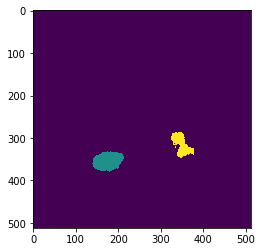

In [59]:
segments_slice = segments[:, :, n_slice]
recon = label_reconstruct(label_slice, segments_slice)
plt.imshow(recon)

In [66]:
features = feature_extract(image, segments, 2048, 64)

In [70]:
adj_arr = adj_generate(features, segments, 0.5)

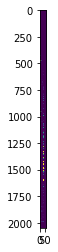

In [71]:
plt.imshow(features)

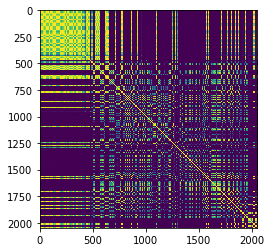

In [69]:
plt.imshow(adj_arr)

In [67]:
def max_min_normalize(img):
    img = np.asarray(img)
    return (img-np.min(img)) / ((np.max(img)-np.min(img) + 1e-10))


def value_count(arr, num):
    """
    Args:
        arr: value 0~1 (numpy.ndarray)
    Returns:
        arr of value count: (numpy.ndarray)
    """
    arr = arr.flatten()
    arr = (arr * (num-1)).astype(np.int32)
    cnt_arr = np.zeros(num).astype(np.int32)
    for i in range(arr.shape[0]):
        cnt_arr[arr[i]] += 1
    return cnt_arr / (cnt_arr.max() + 1e-10)


def feature_extract(img, segments, v_num, f_num):
    features = np.zeros((v_num, f_num))
    for i in tqdm(range(v_num)):
        area = img[np.where(segments==i)]
        features[i] = value_count(area, f_num)
    return features 


def adj_generate(features, segments, tao):
    centroid = []
    range_num = np.minimum(features.shape[0], (segments.max()+1))
#     for i in range(range_num):
#         centroid.append((np.where(segments==i)[0].mean(), np.where(segments==i)[1].mean()))
#     centroid = np.asarray(centroid)
    adj_arr = np.zeros((features.shape[0], features.shape[0]))
    for i in tqdm(range(range_num)):
        for j in range(i+1, range_num):
#             if LA.norm(centroid[i] - centroid[j]) > (segments.shape[0]*threshold):
#                 adj_arr[i, j] = 0
#             else:
#                 e_dist = LA.norm((features[i] - features[j]))
#                 tmp = -1 * e_dist * e_dist / (2*tao*tao)
#                 adj_arr[i, j] = math.exp(tmp)
            e_dist = LA.norm((features[i] - features[j]))
            tmp = -1 * e_dist * e_dist / (2*tao*tao)
            adj_arr[i, j] = math.exp(tmp)
            adj_arr[j, i] = adj_arr[i, j]
    adj_arr += np.eye(features.shape[0])
    return adj_arr


def label_transform(label, segments, v_num, f_num):
    gcn_label = np.zeros((v_num, 1))
    n_range = int(np.minimum(v_num, segments.max()+1))
    for i in range(n_range):
        gcn_label[i] = int(np.median(label[np.where(segments==i)]))
    return gcn_label

def label_reconstruct_3d(label, segments):
    label_recon = np.zeros((label.shape[0], label.shape[1], label.shape[2]))
    id_list = list(np.unique(segments))
    for i in id_list:
        label_recon[np.where(segments==i)] = int(np.median(label[np.where(segments==i)].flatten()))
    return label_recon

def label_reconstruct(label, segments):
#     label_recon = np.zeros((label.shape[0], label.shape[1]))
    label_recon = np.zeros_like(label)
    id_list = list(np.unique(segments))
    for i in id_list:
        label_recon[np.where(segments==i)] = int(np.median(label[np.where(segments==i)].flatten()))
    return label_recon

0.7942583732057417